In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence

#Pandas settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.set_theme(style="whitegrid")

In [2]:
#change directory for your path
os.chdir('E:\\OneDrive\\Documents\\GitHub\\eHealthEquity\\Research\\Data Source')

In [3]:
df = pd.read_csv('final_merge.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3076 entries, 0 to 3075
Data columns (total 46 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   county                      3076 non-null   object 
 1   state                       3076 non-null   object 
 2   ruca                        3073 non-null   float64
 3   brfss_access2_ageadjprv     3076 non-null   float64
 4   brfss_checkup_ageadjprv     3076 non-null   float64
 5   brfss_csmoking_ageadjprv    3076 non-null   float64
 6   brfss_depression_ageadjprv  3076 non-null   float64
 7   brfss_diabetes_ageadjprv    3076 non-null   float64
 8   brfss_ghlth_ageadjprv       3076 non-null   float64
 9   brfss_mhlth_ageadjprv       3076 non-null   float64
 10  brfss_obesity_ageadjprv     3076 non-null   float64
 11  pct_ed_lt9                  3076 non-null   float64
 12  pct_ed_9_12                 3076 non-null   float64
 13  pct_ed_hs                   3076 

# Linear Regression Assumptions Check
Linearity
Linearity between the dependent variable and the independent variables **PASS**

Independence
No auto-correlation in the data (i.e. the data is not time-series data) **PASS** 

No Multicollinearity
No or little multicollinearity between the independent variables **PASS** 

Normality of Residuals
The residuals are normally distributed **PASS** 

Homoscedasticity
Homoscedasticity  **PASS**

In [5]:
dv = [
    'brfss_diabetes_ageadjprv' # percentage of adults aged >=18 years who have diagnosed diabetes
]
iv = [
    'pct_dg_bb_int' # percentage of households with broadband internet access
]
covariates = [
    "brfss_access2_ageadjprv", # percentage of adults without health insurance
    "brfss_checkup_ageadjprv", # percentage of adults aged >=18 years who had a checkup in the past 12 months
    #"brfss_csmoking_ageadjprv", # percentage of adults aged >=18 years who are current smokers
    "brfss_mhlth_ageadjprv", # percentage of adults aged >=18 years who report 14 or more days of poor mental health in the past 30 days
    "brfss_obesity_ageadjprv", # percentage of adults aged >=18 years who have obesity
    "pct_ed_lt9", # percentage of adults aged >=25 years with less than a 9th grade education
    "pct_ed_9_12", # percentage of adults aged >=25 years with a 9th to 12th grade education and no diploma
    "pct_ed_hs", # percentage of adults aged >=25 years with a high school diploma or GED
    #"pct_ed_sc", # percentage of adults aged >=25 years with some college (1-4 years)
    "pct_ed_asc", # percentage of adults aged >=25 years with an associate's degree
    #"pct_ed_b", # percentage of adults aged >=25 years with a bachelor's degree
    # "pct_ed_gr", # percentage of adults aged >=25 years with a graduate or professional degree
    "pct_age_gte65", # percentage of adults aged >=65 years
    "pct_occ_unemp", #  percentage of employed adults aged >=16 years who are unemployed
    # "pct_occ_mgt", # percentage of employed adults aged >=16 years who work in management, business, science, and arts occupations
    #"pct_occ_svc", # percentage of employed adults aged >=16 years who work in service occupations
    #"pct_occ_sales", # percentage of employed adults aged >=16 years who work in sales and office occupations
    # "pct_occ_nat_res", # percentage of employed adults aged >=16 years who work in natural resources, construction, and maintenance occupations
    # "pct_occ_prod", # percentage of employed adults aged >=16 years who work in production, transportation, and material moving occupations
    "pct_ses_pov",  # percentage of all people in poverty
    "pct_tp_veh_0", # percentage of households with zero vehicles
    # "pct_tp_veh_1", # percentage of households with one vehicle
    # "pct_tp_veh_2", # percentage of households with two vehicles
    # "pct_tp_veh_3" # percentage of households with three or more vehicles
    #"ruca", # rural-urban continuum codes
    #"ruca_metro", # metropolitan
    #"ruca_micro", # micropolitan
    #"ruca_small_town", # small town
    "ruca_rural", # rural
    "bb_int_struct" # broadband internet access availability 
]

# variables commented out due to high VIF values (>= 5


In [6]:
X = df[iv + covariates]
y = df[dv]
#center X
X = X - X.mean()
#add constant
X = sm.add_constant(X)

# Linear Regression and Assumptions Check

                     Results: Ordinary least squares
Model:              OLS                      Adj. R-squared:     0.905    
Dependent Variable: brfss_diabetes_ageadjprv AIC:                6518.5437
Date:               2024-01-03 16:18         BIC:                6615.0459
No. Observations:   3076                     Log-Likelihood:     -3243.3  
Df Model:           15                       F-statistic:        1954.    
Df Residuals:       3060                     Prob (F-statistic): 0.00     
R-squared:          0.905                    Scale:              0.48486  
--------------------------------------------------------------------------
                           Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------------
const                     10.5643   0.0126 841.4510 0.0000 10.5397 10.5890
pct_dg_bb_int             -0.0233   0.0026  -9.0037 0.0000 -0.0284 -0.0182
brfss_access2_ageadjprv    0.1102   0.0034  32.

,VIF,Tolerance,features
0,1.000,1.000,const
1,2.640,0.380,pct_dg_bb_int
2,2.360,0.420,brfss_access2_ageadjprv
3,1.520,0.660,brfss_checkup_ageadjprv
4,3.260,0.310,brfss_mhlth_ageadjprv
5,2.520,0.400,brfss_obesity_ageadjprv
6,2.030,0.490,pct_ed_lt9
7,2.990,0.330,pct_ed_9_12
8,2.190,0.460,pct_ed_hs
9,1.510,0.660,pct_ed_asc


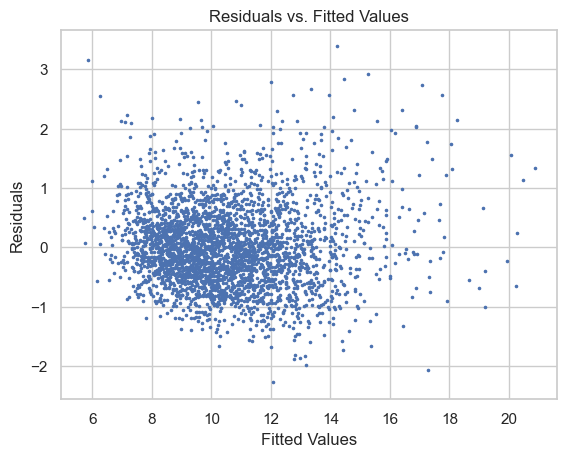

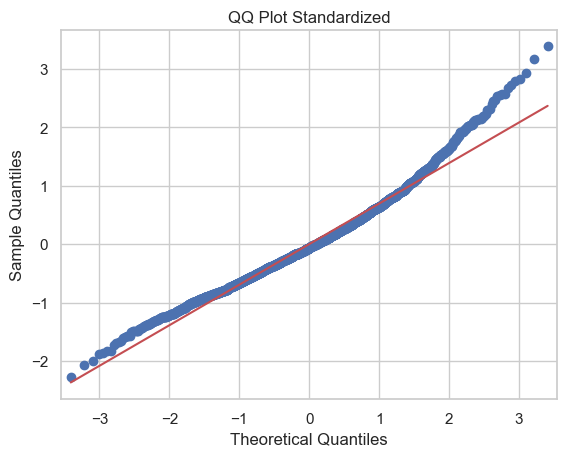

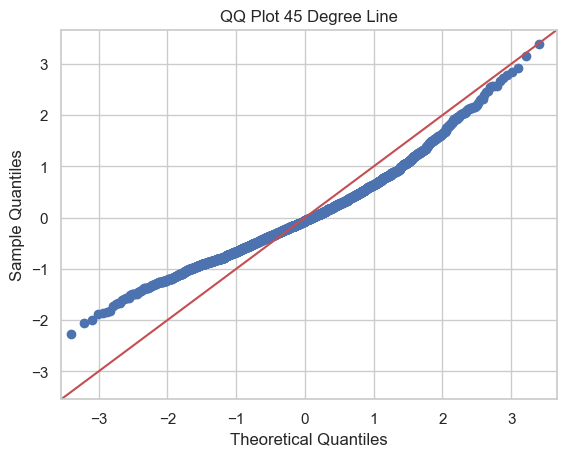

In [7]:
model = sm.OLS(y, X)
results = model.fit()

#Evalute VIF for each variable and display in table
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Tolerance"] = [1 / tolerance for tolerance in vif["VIF"]]
vif["features"] = X.columns

#Make MAE and RMSE scores 
mae = np.mean(np.abs(results.resid))
rmse = np.sqrt(np.mean(results.resid**2))

#Reg Model Summary, MAE, and VIF display
print(results.summary2())
print("MAE: ", mae)
print("RMSE: ", rmse)
display(vif.round(2))

#Assess for heteroskedasticity and normality of residuals
residuals = results.resid
plt.scatter(results.fittedvalues, residuals, s=2.5)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

#QQ Plot with Standardized line
sm.qqplot(residuals, line='s')
plt.title('QQ Plot Standardized')
plt.show()

#QQ Plot with 45 degree line
sm.qqplot(residuals, line='45')
plt.title('QQ Plot 45 Degree Line')
plt.show()

In [8]:
summary_df = pd.read_html(results.summary().tables[1].as_html(), header=0, index_col=0)[0]
summary_df = summary_df.reset_index()
summary_df = summary_df.rename(columns={'index':'feature'})
print(summary_df)

                    feature   coef  std err       t  P>|t|  [0.025  0.975]
0                     const 10.564    0.013 841.451  0.000  10.540  10.589
1             pct_dg_bb_int -0.023    0.003  -9.004  0.000  -0.028  -0.018
2   brfss_access2_ageadjprv  0.110    0.003  32.197  0.000   0.103   0.117
3   brfss_checkup_ageadjprv  0.064    0.003  18.539  0.000   0.058   0.071
4     brfss_mhlth_ageadjprv  0.070    0.011   6.547  0.000   0.049   0.091
5   brfss_obesity_ageadjprv  0.115    0.004  26.138  0.000   0.106   0.123
6                pct_ed_lt9  0.019    0.005   3.751  0.000   0.009   0.029
7               pct_ed_9_12  0.086    0.006  13.665  0.000   0.074   0.099
8                 pct_ed_hs -0.027    0.002 -10.839  0.000  -0.032  -0.022
9                pct_ed_asc -0.023    0.005  -4.343  0.000  -0.033  -0.012
10            pct_age_gte65 -0.035    0.003 -10.482  0.000  -0.042  -0.029
11            pct_occ_unemp  0.125    0.011  11.329  0.000   0.103   0.147
12              pct_ses_p

In [9]:
fit_measures = pd.DataFrame()
fit_measures['MAE'] = [mae]
fit_measures['RMSE'] = [rmse]
fit_measures['R2'] = [results.rsquared]
fit_measures['Adj. R2'] = [results.rsquared_adj]
fit_measures['F-statistic'] = [results.fvalue]
fit_measures['p-value'] = [results.f_pvalue]
fit_measures['AIC'] = [results.aic]
fit_measures['BIC'] = [results.bic]
fit_measures['Log-Likelihood'] = [results.llf]
fit_measures['df_resid'] = [results.df_resid]
fit_measures['df_model'] = [results.df_model]

display(fit_measures.round(2))

,MAE,RMSE,R2,Adj. R2,F-statistic,p-value,AIC,BIC,Log-Likelihood,df_resid,df_model
0,0.530,0.690,0.910,0.910,1954.370,0.000,6518.540,6615.050,-3243.270,3060.000,15.000


## Outlier Assessment and Removal 

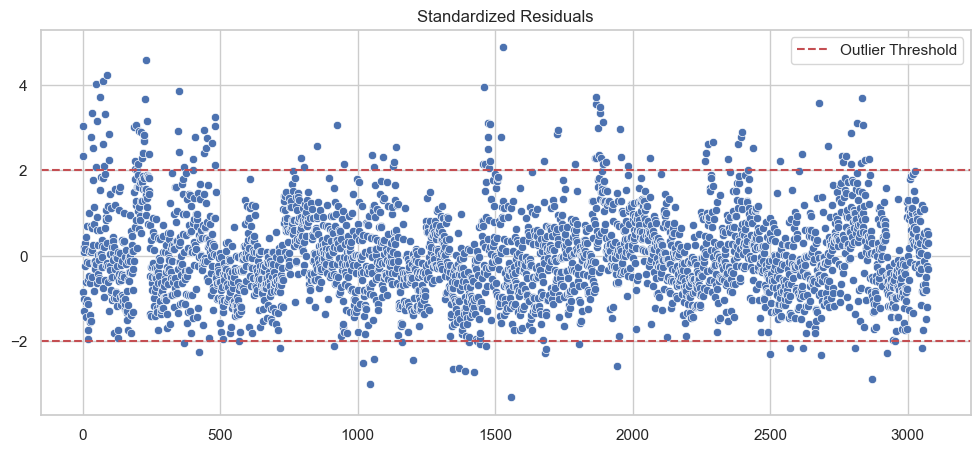

False    2886
True      190
Name: outliers, dtype: int64

0.0013003901170351106
3076


In [10]:
#outlier detection Cook's Distance
influence = OLSInfluence(results)
standardized_residuals = influence.resid_studentized_internal
leverage = influence.hat_matrix_diag
cooks_d = influence.cooks_distance

plt.figure(figsize=(12, 5))
sns.scatterplot(x=range(len(standardized_residuals)), y=standardized_residuals)
plt.axhline(y=2, color='r', linestyle='--', label='Outlier Threshold')
plt.axhline(y=-2, color='r', linestyle='--')
plt.title('Standardized Residuals')
plt.legend()
plt.show()

df_outliers = df.copy()
df_outliers['standardized_residuals'] = standardized_residuals
df_outliers['leverage'] = leverage
df_outliers['cooks_d'] = cooks_d[0]

#identify outliers using Cook's Distance 4/(n-k-1)
df_outliers['outliers'] = df_outliers['cooks_d'] > (4/(len(df_outliers)-len(iv)-1))
df_outliers[df_outliers['outliers'] == True]
display(df_outliers['outliers'].value_counts())

print(4/len(df_outliers))
print(len(df_outliers))


In [11]:
# remove outliers
df_no_outliers = df_outliers[df_outliers['outliers'] == False]
#drop outlier columns
df_no_outliers = df_no_outliers.drop(columns=['standardized_residuals', 'leverage', 'cooks_d', 'outliers'])
# set x and y with outliers removed
X = df_no_outliers[iv + covariates]
y = df_no_outliers[dv]
#center X
X = X - X.mean()
#add constant
X = sm.add_constant(X)

                     Results: Ordinary least squares
Model:              OLS                      Adj. R-squared:     0.921    
Dependent Variable: brfss_diabetes_ageadjprv AIC:                5008.0996
Date:               2024-01-03 16:18         BIC:                5103.5817
No. Observations:   2886                     Log-Likelihood:     -2488.0  
Df Model:           15                       F-statistic:        2246.    
Df Residuals:       2870                     Prob (F-statistic): 0.00     
R-squared:          0.922                    Scale:              0.33019  
--------------------------------------------------------------------------
                           Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------------
const                     10.3870   0.0107 971.0918 0.0000 10.3661 10.4080
pct_dg_bb_int             -0.0189   0.0024  -7.7364 0.0000 -0.0236 -0.0141
brfss_access2_ageadjprv    0.1133   0.0031  36.

,VIF,Tolerance,features
0,1.000,1.000,const
1,2.700,0.370,pct_dg_bb_int
2,2.500,0.400,brfss_access2_ageadjprv
3,1.490,0.670,brfss_checkup_ageadjprv
4,3.390,0.290,brfss_mhlth_ageadjprv
5,2.340,0.430,brfss_obesity_ageadjprv
6,2.170,0.460,pct_ed_lt9
7,3.180,0.310,pct_ed_9_12
8,2.260,0.440,pct_ed_hs
9,1.530,0.650,pct_ed_asc


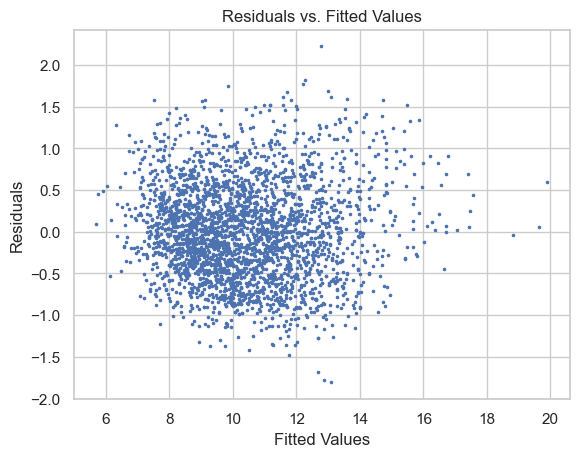

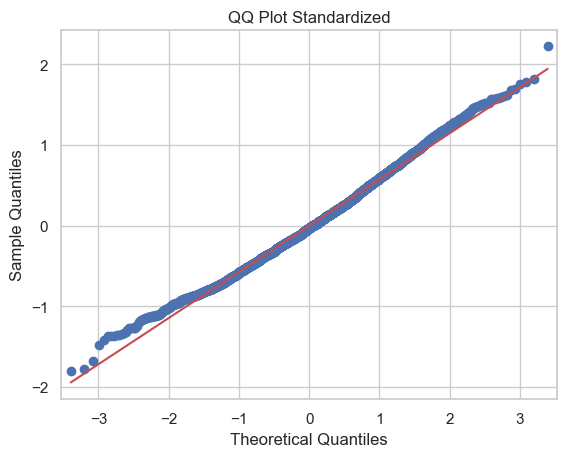

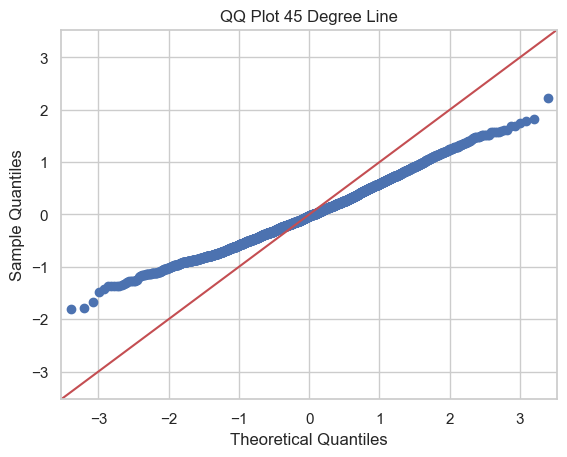

In [12]:
model = sm.OLS(y, X)
results = model.fit()

#Evalute VIF for each variable and display in table
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Tolerance"] = [1 / tolerance for tolerance in vif["VIF"]]
vif["features"] = X.columns

#Make MAE and RMSE scores 
mae = np.mean(np.abs(results.resid))
rmse = np.sqrt(np.mean(results.resid**2))

#Reg Model Summary, MAE, and VIF display
print(results.summary2())
print("MAE: ", mae)
print("RMSE: ", rmse)
display(vif.round(2))

#Assess for heteroskedasticity and normality of residuals
residuals = results.resid
plt.scatter(results.fittedvalues, residuals, s=2.5)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

#QQ Plot with Standardized line
sm.qqplot(residuals, line='s')
plt.title('QQ Plot Standardized')
plt.show()

#QQ Plot with 45 degree line
sm.qqplot(residuals, line='45')
plt.title('QQ Plot 45 Degree Line')
plt.show()

In [13]:
fit_measures_2 = pd.DataFrame()
fit_measures_2['MAE'] = [mae]
fit_measures_2['RMSE'] = [rmse]
fit_measures_2['R2'] = [results.rsquared]
fit_measures_2['Adj. R2'] = [results.rsquared_adj]
fit_measures_2['F-statistic'] = [results.fvalue]
fit_measures_2['p-value'] = [results.f_pvalue]
fit_measures_2['AIC'] = [results.aic]
fit_measures_2['BIC'] = [results.bic]
fit_measures_2['Log-Likelihood'] = [results.llf]
fit_measures_2['df_resid'] = [results.df_resid]
fit_measures_2['df_model'] = [results.df_model]

print('OLS')
display(fit_measures.round(2))
print('OLS with outliers removed')
display(fit_measures_2.round(2))

OLS


,MAE,RMSE,R2,Adj. R2,F-statistic,p-value,AIC,BIC,Log-Likelihood,df_resid,df_model
0,0.530,0.690,0.910,0.910,1954.370,0.000,6518.540,6615.050,-3243.270,3060.000,15.000


OLS with outliers removed


,MAE,RMSE,R2,Adj. R2,F-statistic,p-value,AIC,BIC,Log-Likelihood,df_resid,df_model
0,0.460,0.570,0.920,0.920,2246.170,0.000,5008.100,5103.580,-2488.050,2870.000,15.000


In [14]:
#Outlier remove Model coefficients

summary_df = pd.read_html(results.summary().tables[1].as_html(), header=0, index_col=0)[0]
summary_df = summary_df.reset_index()
summary_df = summary_df.rename(columns={'index':'feature'})
print(summary_df)

                    feature   coef  std err       t  P>|t|  [0.025  0.975]
0                     const 10.387    0.011 971.092  0.000  10.366  10.408
1             pct_dg_bb_int -0.019    0.002  -7.736  0.000  -0.024  -0.014
2   brfss_access2_ageadjprv  0.113    0.003  36.334  0.000   0.107   0.119
3   brfss_checkup_ageadjprv  0.073    0.003  23.351  0.000   0.067   0.079
4     brfss_mhlth_ageadjprv  0.107    0.009  11.376  0.000   0.089   0.126
5   brfss_obesity_ageadjprv  0.110    0.004  28.968  0.000   0.103   0.118
6                pct_ed_lt9  0.022    0.005   4.156  0.000   0.012   0.033
7               pct_ed_9_12  0.084    0.006  14.305  0.000   0.072   0.095
8                 pct_ed_hs -0.026    0.002 -11.915  0.000  -0.030  -0.022
9                pct_ed_asc -0.019    0.005  -4.186  0.000  -0.029  -0.010
10            pct_age_gte65 -0.034    0.003 -11.214  0.000  -0.039  -0.028
11            pct_occ_unemp  0.115    0.011  10.617  0.000   0.093   0.136
12              pct_ses_p